In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import pickle
from collections import OrderedDict
from scipy import optimize

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 600
#mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Results files should be made previously using:
`./alt_aggregate_results.py` and by setting the correct `date` and `regions`

In [2]:
test = True

pdf = True
svg = True

xlab = 'Number of years of input data'

ALT_YRS = False
#ALT_YRS = True
if ALT_YRS:
    xlab = 'Median number of unique\nyears of input data'

yrs_nums_alt = [1, 2, 3, 4, 5, 7, 9, 13, 20, 26.5]
yrs_labs_alt = ['1', '', '3', '', '5', '7', '9', '13', '20', '26.5']

norm = {
    'ERCOT' : 26308, # Mean demand (MW) for file ERCOT_demand_synthetic_1950-2020_MEM.csv
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}

title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\n'+r'battery + H$_{2}$'
}

year_range = range(1979, 2021)

In [3]:
file_key = {
    'CONUS' : {
        #'SWB' : ['ALL',],
        #'SWBNG' : ['ALL',],
        #'SWBPGP' : ['ALL',],
        'SWB' : ['Jan29v1',],
        'SWBNG' : ['Jan29v1',],
        'SWBPGP' : ['Jan29v1',], 
    },
    #'ERCOT' : {
    #    'SWB' : ['Jan10v1',],
    #    'SWBNG' : ['Jan10v1',],
    #    'SWBPGP' : ['Jan10v1',],
    #    'SWB' : ['ALL',],
    #    'SWBNG' : ['ALL',],
    #    'SWBPGP' : ['ALL',],
    #},
}

def aggregate_results_files(region, techs, dates, post):
    
    files = [f"./n_years_{date}_{region}_{techs}{post}_10YrTests.csv" for date in dates]
    
    for i, f in enumerate(files):
        
        print(f"loading: {f}")
        
        if i == 0:
            df = pd.read_csv(f, index_col=False)
        else:
            tmp = pd.read_csv(f, index_col=False)
            df = df.append(tmp)
    
    return df

def load_data(file_key, test):

    post = '' if not test else '_TestArchs'
    dfs = {}
    df2s = {}
    for region, tech_list in file_key.items():
        print(region)
        dfs[region] = {}
        df2s[region] = {}
        for techs, dates in tech_list.items():
            print(f" --- {techs}, {dates}")
            
            
            df = aggregate_results_files(region, techs, dates, post)
            df = df.sort_values(by=['n_years', 'scale_factor'])
            # This line was helpful when I ran older ERA5 years and is not needed now.
            #df = df[ (df['opt_years'] < 25) | (df['opt_years'] >= 79)]
            #df = df[ (df['test_years'] >= 1979) ]
            df.to_csv(f"./n_years_ALL_{region}_{techs}{post}_10YrTests.csv", index=False)
            dfs[region][techs] = df
            for NYEARS in df['n_years'].unique():
                print(f" ------ {NYEARS}: {len(df.loc[ df['n_years'] == NYEARS ].index)}")
    
            print(f" ------ TOTAL: {len(dfs[region][techs].index)}")
    
            df2 = build_associated_df_NEW(df)
            #print(df2)
            df2s[region][techs] = df2

    return dfs, df2s

In [4]:
def build_associated_df_NEW(df):
    
    cols = ['syst_cost', 'lost_load']
    for c in df.columns:
        if 'capacity' in c:
            cols.append(c)
    
    DF = {'n_years' : []}
    
    vals = ['min', 'max', 'mean', 'median', '25p', '75p', '90p', '95p', '99p', 'std']
    
    for col in cols:
        for val in vals:
            DF[f"{col}_{val}"] = []
    
    for NYEARS in df['n_years'].unique():
        tmp = df.loc[ (df['n_years'] == NYEARS) ]#& (df['test_year'] > 0) ]
        
        ### Some files did not finish
        if len(tmp.index) == 0:
            continue
        
        DF['n_years'].append(NYEARS)
        
        for col in cols:
            
            DF[f"{col}_min"].append(np.min(tmp[col]))
            DF[f"{col}_max"].append(np.max(tmp[col]))
            DF[f"{col}_mean"].append(np.mean(tmp[col]))
            DF[f"{col}_median"].append(np.median(tmp[col]))
            DF[f"{col}_25p"].append(np.percentile(tmp[col], 25))
            DF[f"{col}_75p"].append(np.percentile(tmp[col], 75))
            DF[f"{col}_90p"].append(np.percentile(tmp[col], 90))
            DF[f"{col}_95p"].append(np.percentile(tmp[col], 95))
            DF[f"{col}_99p"].append(np.percentile(tmp[col], 99))
            DF[f"{col}_std"].append(np.std(tmp[col]))
    
    DF = pd.DataFrame(DF)
    
    return DF

dfs, df2s = load_data(file_key, test)

CONUS
 --- SWB, ['Jan29v1']
loading: ./n_years_Jan29v1_CONUS_SWB_TestArchs_10YrTests.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ TOTAL: 3820
 --- SWBNG, ['Jan29v1']
loading: ./n_years_Jan29v1_CONUS_SWBNG_TestArchs_10YrTests.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ TOTAL: 3820
 --- SWBPGP, ['Jan29v1']
loading: ./n_years_Jan29v1_CONUS_SWBPGP_TestArchs_10YrTests.csv
 ------ 1: 500
 ------ 2: 500
 ------ 3: 500
 ------ 4: 500
 ------ 5: 500
 ------ 7: 500
 ------ 10: 500
 ------ 15: 150
 ------ 25: 150
 ------ 40: 20
 ------ TOTAL: 3820


# Figure 1

CONUS dict_keys(['SWB', 'SWBNG', 'SWBPGP'])
SWB Len variables 0
R2 = 0.9988
a = 0.00102 +/- 1.077%
b = -1.05617 +/- -1.633%
SWBNG Len variables 0
R2 = 0.9980
a = 0.00013 +/- 1.347%
b = -0.97514 +/- -2.014%
SWBPGP Len variables 0
R2 = 0.9859
a = 0.01085 +/- 3.184%
b = -0.60120 +/- -4.919%


<ipython-input-5-3e0f36bbc24e>:158: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i].set_ylim(0, .035)
<ipython-input-5-3e0f36bbc24e>:158: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i].set_ylim(0, .035)


Saving: plots/fig1_lost_load.png


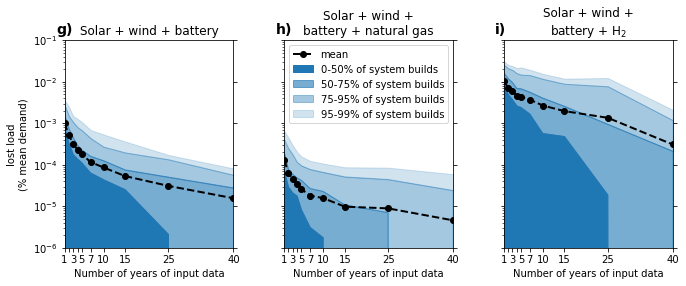

In [5]:
def plot_vars(techs):

    kwargs = {}
    kwargs['techs'] = techs
    kwargs['y_lab'] = 'lost load\n(fraction mean demand)'
    kwargs['y_min'] = 0
    kwargs['left_legend'] = True
    kwargs['y_lab'] = 'system cost ($/kWh)'
    #del kwargs['y_min']
    kwargs['test'] = test
    
    kwargs['y_min'] = 0
    kwargs['percentile'] = False
    kwargs['y_labs'] = ['system cost ($/kWh)',]

    kwargs['max_yr'] = 20
    #if kwargs['techs'] == 'SWBPGP':
    #    kwargs['max_yr'] = 10
    
    variables = []
    

    return variables, kwargs




def plot_LL_for_region(save_name, dfs, logY, log_y_data):
    
    cols = len(dfs.keys())
    fig, axs = plt.subplots(ncols=cols, sharey=True, figsize=((3+cols*3)*.8, 4.8*.8))
    if cols == 1:
        axs = [axs,]
    fig.patch.set_facecolor('white')
        
    label_dict = {
        0 : "g)",
        1 : "h)",
        2 : "i)"
    }
    
    i = 0
    outs = OrderedDict()
    fits = {}
    for techs, df in dfs.items():
        outs[techs] = OrderedDict()
        df2 = df[ df['n_years'] <= 40 ]
        variables, kwargs = plot_vars(techs)
        print(techs, f"Len variables {len(variables)}")
    
        if not ALT_YRS:
            axs[i].set_title(title_map[techs])
        axs[i].text(-0.05, 1.03, label_dict[i], fontsize=14, weight='bold', transform=axs[i].transAxes)
    
            
        yrs = df2['n_years']
        if ALT_YRS:
            df_tmp = pd.DataFrame({'yrs' : yrs_nums_alt})
            yrs = df_tmp['yrs']
        #if cnt == 0:
        
        # Just added y-axis that we're showing power capacity
        denom = norm[region]

            
        # Lost load has special naming...
        """
        #p = axs[i].plot(yrs, df["lost_load_max"]/denom, ls='--', label=r"max")
        p = axs[i].plot(yrs, df[f"lost_load_99p"]/denom, ls='--', label=r"99th percentile")
        #axs[i].plot(yrs, df['lost_load_99p']/denom, c=p[-1].get_color(), ls=':', label=r"99th percentile")
        ###p = axs[i].plot(yrs, df['lost_load_95p']/denom, ls='--', label=r"95th percentile")
        axs[i].plot(yrs, df['lost_load_95p']/denom, c=p[-1].get_color(), ls='--', label=r"95th percentile")
        axs[i].plot(yrs, df['lost_load_90p']/denom, c=p[-1].get_color(), ls=':', label=r"90th percentile")
        axs[i].plot(yrs, df['lost_load_75p']/denom, c=p[-1].get_color(), ls='-.', label=r"75th percentile")
        axs[i].plot(yrs, df['lost_load_median']/denom, marker='o', c=p[-1].get_color(), linestyle='-', label='median')
        """
        
        
        if not log_y_data:
            axs[i].plot(yrs, df['lost_load_mean']/denom, marker='o', c='k', linestyle='--', label='mean')
            popt, pcov = optimize.curve_fit(power_fit, yrs, df['lost_load_mean']/denom)
            #axs[i].plot(yrs, power_fit(yrs, *popt), 'r-', label='power law fit')
            r_squared_and_text(techs, axs[i], yrs, df['lost_load_mean']/denom, power_fit, popt, 'power law', logY)
        
        
        if log_y_data:
            lyrs = np.log(yrs)
            axs[i].plot(lyrs, np.log(df['lost_load_mean']/denom), marker='o', c='k', linestyle='--', label='mean')
            popt, pcov = optimize.curve_fit(linear_fit, lyrs, np.log(df['lost_load_mean']/denom))
            #axs[i].plot(lyrs, linear_fit(lyrs, *popt), 'r-', label='linear fit')
            r_squared_and_text(techs, axs[i], lyrs, np.log(df['lost_load_mean']/denom), linear_fit, popt, 'linear', logY)
        perr = np.sqrt(np.diag(pcov))
        for k, letter in enumerate(['a', 'b']):
            print(f"{letter} = {popt[k]:.5f} +/- {perr[k]/popt[k]*100:.3f}%")
        #print(popt)
        #print(perr)
        fits[techs] = popt
        
        if not log_y_data:
            # Invert order for fill_between
            bottom = df['lost_load_min']/denom
            axs[i].fill_between(yrs, bottom, df['lost_load_median']/denom, color='C0', alpha=1.0, label='0-50% of system builds')
            bottom = df['lost_load_median']/denom
            axs[i].fill_between(yrs, bottom, df['lost_load_75p']/denom, color='C0', alpha=0.6, label='50-75% of system builds')
            bottom = df['lost_load_75p']/denom
            axs[i].fill_between(yrs, bottom, df['lost_load_95p']/denom, color='C0', alpha=0.4, label='75-95% of system builds')
            bottom = df['lost_load_95p']/denom
            axs[i].fill_between(yrs, bottom, df['lost_load_99p']/denom, color='C0', alpha=0.2, label='95-99% of system builds')
            bottom = df['lost_load_99p']/denom
        
        if log_y_data:
            # Invert order for fill_between
            #bottom = np.log(df['lost_load_min']/denom)
            axs[i].plot(lyrs, np.log(df['lost_load_median']/denom), color='C0', alpha=1.0, label='50%')
            #bottom = np.log(df['lost_load_median']/denom)
            axs[i].plot(lyrs, np.log(df['lost_load_75p']/denom), color='C0', alpha=0.6, label='75%')
            #bottom = np.log(df['lost_load_75p']/denom)
            axs[i].plot(lyrs, np.log(df['lost_load_95p']/denom), color='C0', alpha=0.4, label='95%')
            #bottom = np.log(df['lost_load_95p']/denom)
            axs[i].plot(lyrs, np.log(df['lost_load_99p']/denom), color='C0', alpha=0.2, label='99%')
            #bottom = np.log(df['lost_load_99p']/denom)

        
        outs[techs]['n_years'] = yrs.values
        outs[techs]['lost_load_99p'] = df['lost_load_99p'].values/denom * 100
        outs[techs]['lost_load_95p'] = df['lost_load_95p'].values/denom * 100
        #outs[techs]['lost_load_90p'] = df['lost_load_90p'].values/denom * 100
        outs[techs]['lost_load_75p'] = df['lost_load_75p'].values/denom * 100
        outs[techs]['lost_load_median'] = df['lost_load_median'].values/denom * 100
        outs[techs]['lost_load_min'] = df['lost_load_min'].values/denom * 100
        outs[techs]['lost_load_mean'] = df['lost_load_mean'].values/denom * 100

        axs[i].set_xlabel(xlab)
        if log_y_data:
            axs[i].set_xlabel(f'ln({xlab})')
        yrs_labs = []
        for y in yrs:
            skip_lab = [] if np.max(yrs) == 5 else [2, 4]
            yrs_labs.append(str(y)) if y not in skip_lab else yrs_labs.append('')
        if not log_y_data:
            axs[i].set_xticks(yrs)
            if ALT_YRS:
                axs[i].set_xticklabels(yrs_labs_alt)
            else:
                axs[i].set_xticklabels(yrs_labs)
                
            

        if i == 0:
            axs[i].set_ylabel('lost load\n(% mean demand)')
            if log_y_data:
                axs[i].set_ylabel('ln(lost load)\n(% mean demand)')
        
        if not log_y_data:
            MAX = axs[i].get_ylim()[1]
            if MAX > 0.01:
                deci = 1
                axs[i].set_ylim(0, .035)
            elif MAX > 0.003:
                deci = 2
                axs[i].set_ylim(0, .004)
            else:
                deci = 2
                axs[i].set_ylim(0, .0007)
            axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=deci))
        if logY:
            axs[i].set_ylim(1e-6, .1)
            axs[i].set_yscale('log')
        if log_y_data:
            axs[i].set_ylim(-14, 0)
        
        #if 'y_min' in kwargs.keys():
        #    axs[i].set_ylim(kwargs['y_min'], axs[i].get_ylim()[1])
        if 'y_buffer' in kwargs.keys():
            axs[i].set_ylim(axs[i].get_ylim()[0], axs[i].get_ylim()[1]*kwargs['y_buffer'])
        
        if not log_y_data:
            axs[i].set_xlim(1, kwargs['max_yr'])
            if 40 in yrs.values:
                axs[i].set_xlim(axs[i].get_xlim()[0], 40)
            if ALT_YRS:
                axs[i].set_xlim(yrs_nums_alt[0], yrs_nums_alt[-1])
        axs[i].tick_params(right=True)
        #axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=2))
        #axs[i].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
        i += 1
    
    axs[-2].legend(loc='upper right')
        

    for k, v in outs.items():
        for k2, v2 in v.items():
            S = f'{k},{k2},'
            for vs in v2:
                S += f'{vs},'
            #print(S)
    
    
    #plt.tight_layout(pad=1)
    plt.subplots_adjust(left=.11, right=.99, wspace=.3, bottom=.13, top=.88)
    if ALT_YRS:
        plt.subplots_adjust(left=.11, right=.99, wspace=.3, bottom=.18, top=.92)
    if pdf:
        plt.savefig(f"plots/{save_name}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}.svg")
    plt.savefig(f"plots/{save_name}.png")
    print(f"Saving: plots/{save_name}.png")
    return fits

   

def exp_fit(x, a, b):
    return a * np.exp(b * x)

def power_fit(x, a, b):
    return a * np.power((x), b)

def linear_fit(x, a, b):
    return a + x * b

def r_squared_and_text(techs, ax, xdata, ydata, f, popt, fit_type, logY):
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R2 = {r_squared:.4f}")
    if fit_type == 'power law':
        y = .25
        if logY and techs == 'SWB':
            y = .65
        if logY and techs == 'SWBNG':
            y = .415
        if not logY and techs == 'SWBPGP':
            y = .65
        #ax.text(.2, y, f"y = {popt[0]:.3} * x^({popt[1]:.3f})\n"+r"R$^{2}$"+f" = {r_squared:.3f}", transform=ax.transAxes)
    elif fit_type == 'linear':
        y = .65
        if techs == 'SWBNG':
            y = .415
        if techs == 'SWBPGP':
            y = .05
        #ax.text(.2, y, f"y = {popt[0]:.3} + x * ({popt[1]:.3f})\n"+r"R$^{2}$"+f" = {r_squared:.3f}", transform=ax.transAxes)

fits = {}
for region, tech_list in dfs.items():
    print(region, tech_list.keys())
    fits[region] = {}
    #kwargs['sup_title'] = f"{title_map[techs]}"
    #fits[region]['power law'] = plot_LL_for_region(f"figS1_linear", df2s[region], logY=False, log_y_data=False)
    plot_LL_for_region(f"fig1_lost_load", df2s[region], logY=True, log_y_data=False)
    #fits[region]['linear'] = plot_LL_for_region(f"figS1_logTransform", df2s[region], logY=False, log_y_data=True)

Saving: plots/fig5.png


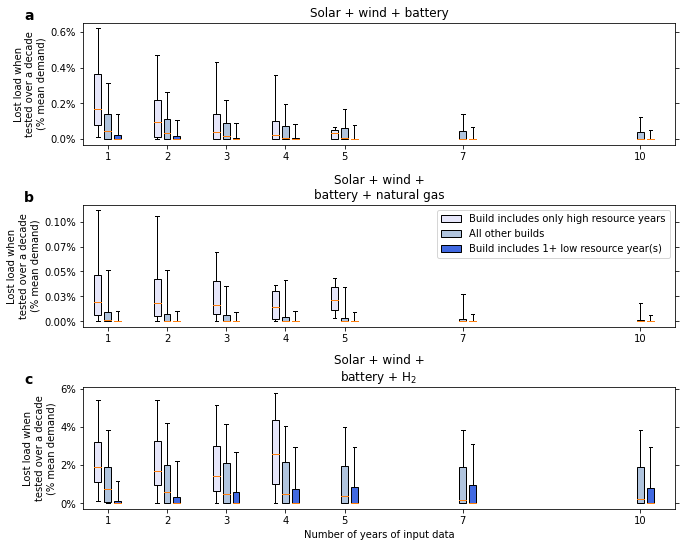

In [8]:
def get_groupings(techs):    
    return list(pd.read_csv(f'May31v2_CONUS_{techs}_max_LL_opt_years.csv')['year']), \
            list(pd.read_csv(f'May31v2_CONUS_{techs}_max_LL_test_years.csv')['year'])

def get_years_list(opt_years):
    
    info = opt_years.split('-')
    yrs = []
    for yr in info:
        yr = int(yr)
        if yr > 50:
            yr += 1900
        else:
            yr += 2000
        yrs.append(yr)
    return yrs


# Take initial df and lists of max_opt years & max_test years
# Return idxs containing entries that include that year in the initial optimization
def select_entries_10YrsTest(df, max_opt, max_test):
    
    idx_all_opt_max = []
    idx_single_test_max = []
    idx_other = []

    for idx in df.index:
        opt_years = df.loc[idx, 'opt_years']
        yrs = get_years_list(opt_years)
        ALL_MAX = True # set to false if single year fails
        SINGLE_MAX_TEST = False
        for yr in yrs:
            if yr not in max_opt:
                ALL_MAX = False
            if yr in max_test:
                SINGLE_MAX_TEST = True
        if ALL_MAX:
            idx_all_opt_max.append(idx)
        elif SINGLE_MAX_TEST:
            idx_single_test_max.append(idx)
        else:
            idx_other.append(idx)

    return {'Build includes only high resource years': idx_all_opt_max, 
            'All other builds': idx_other,
            'Build includes 1+ low resource year(s)': idx_single_test_max}


def plot_LL_by_groupings(save_name, max_n_years=10):
    
    cols = 3
    fig, axs = plt.subplots(nrows=cols, figsize=((3+cols*3)*.8, 2*4.8*.8))
    if cols == 1:
        axs = [axs,]
    fig.patch.set_facecolor('white')
    
    label_dict = {
        0 : "a",
        1 : "b",
        2 : "c"
    }
    
    i = 0
    #outs = OrderedDict()
    for techs in ['SWB', 'SWBNG', 'SWBPGP']:
        #outs[techs] = OrderedDict()
        df = pd.read_csv(f"n_years_Jan29v1_CONUS_{techs}_TestArchs.csv")
        df2 = df[ df['n_years'] <= max_n_years ]
    
        axs[i].set_title(title_map[techs])
        axs[i].text(-0.1, 1.03, label_dict[i], fontsize=14, weight='bold', transform=axs[i].transAxes)
            
        yrs = df2['n_years'].unique()
        
        # Just added y-axis that we're showing power capacity
        denom = norm[region]
        
        max_opt, max_test = get_groupings(techs)
        mapping = select_entries_10YrsTest(df2, max_opt, max_test)
        
        alpha=0.1
        bplots = {}
        cnt = 0
        #colors = ['C0', 'C1', 'C2']
        colors = ['lavender', 'lightsteelblue', 'royalblue']
        legend_elements = []
        xvals = 60
        for lab, idxs in mapping.items():
            boxes = [[] for _ in range(xvals)]
            df3 = df2.loc[idxs]
            for NYEARS in df3['n_years'].unique():
                df4 = df3[ df3['n_years'] == NYEARS ]
                boxes[(NYEARS - 1) * 6 + cnt + 1] = list(df4['lost_load']/denom)
                p95=np.percentile(df4['lost_load']/denom,95)
                p75=np.percentile(df4['lost_load']/denom,75)
                p50=np.percentile(df4['lost_load']/denom,50)
                p25=np.percentile(df4['lost_load']/denom,25)
                p05=np.percentile(df4['lost_load']/denom,5)
                mean=np.mean(df4['lost_load']/denom)
                #print(f"{techs},{lab},{NYEARS},{p05},{p25},{p50},{p75},{p95},{mean}")
            bplot = axs[i].boxplot(boxes, whis=(5, 95), widths=.7, patch_artist=True, showfliers=False)
            bplots[lab] = bplot
            for patch in bplot['boxes']:
                patch.set_facecolor(colors[cnt])
            legend_elements.append(
                Patch(facecolor=colors[cnt], edgecolor='k', label=lab)
            )
            cnt += 1
            #axs[i].scatter(df2.loc[idxs]['n_years'], df2.loc[idxs]['lost_load']/denom, label=lab, alpha=alpha)



        axs[i].set_ylabel('Lost load when\ntested over a decade\n(% mean demand)')
        
        MAX = axs[i].get_ylim()[1]
        if MAX > 0.01:
            deci = 0
        elif MAX > 0.004:
            deci = 1
        else:
            deci = 2
        axs[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=deci))
        axs[i].set_xticks(np.array(yrs)*6 - 3)
        axs[i].set_xticklabels(yrs)
            
        #axs[i].set_xlim(axs[i].get_xlim()[0], max_n_years)
        axs[i].tick_params(right=True)
        i += 1
        #break

    
    #axs[-2].legend(loc='upper right')
    axs[-2].legend(handles=legend_elements, loc='upper right')

    axs[-1].set_xlabel(xlab)
    
    
    
    
    plt.tight_layout(pad=1)
    if pdf:
        plt.savefig(f"plots/{save_name}.pdf")
    if svg:
        plt.savefig(f"plots/{save_name}.svg")
    plt.savefig(f"plots/{save_name}.png")
    print(f"Saving: plots/{save_name}.png")
    return

save_name = f"fig5"
plot_LL_by_groupings(save_name)